In [1]:
from scipy import io
import numpy as np

import matplotlib.pyplot as plt


from sklearn.gaussian_process import GaussianProcessRegressor
plt.style.use("seaborn")

from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel, WhiteKernel


from scipy.linalg import cholesky, cho_factor, cho_solve

import scipy

/tmp/ipykernel_250563/1315796348.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [35]:
from matplotlib import cm
print(cm.coolwarm(0.0))

(0.2298057, 0.298717966, 0.753683153, 1.0)


Text(0, 0.5, '$u_0(x)$')

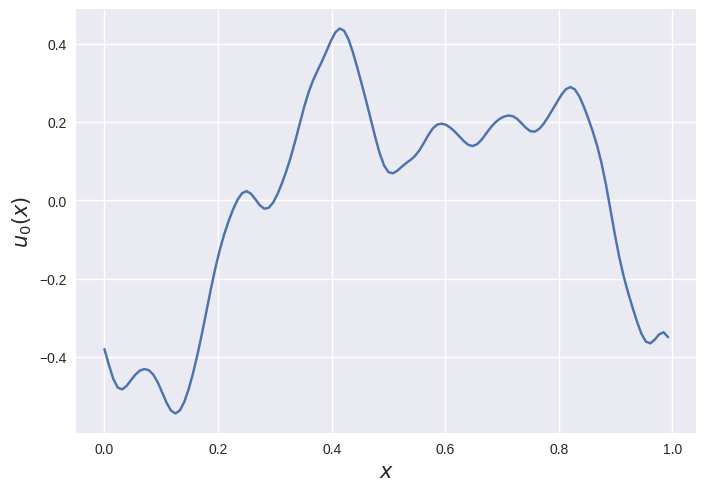

In [2]:
def get_data(ntrain, ntest):
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = io.loadmat("burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]
    
        
    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]
    
    return x_branch_train, y_train, x_branch_test, y_test, grid


    x_train = (x_branch_train, grid)
    x_test = (x_branch_test, grid)
    return x_train, y_train, x_test, y_test


x, y, x_test, y_test, grid = get_data(1000, 200)


idx = 2

plt.figure()
plt.plot(grid, x[idx])
plt.xlabel(r'$x$', size= 15)
plt.ylabel(r'$u_0(x)$', size= 15)


Text(0.5, 1.0, 'Input')

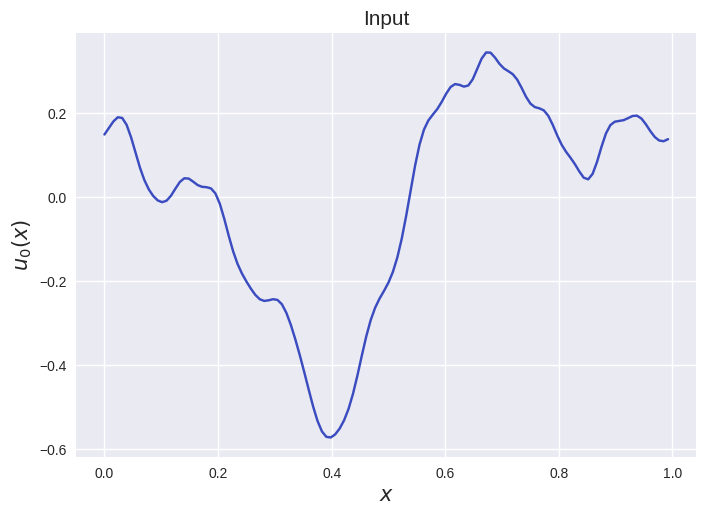

In [49]:
idx = 15

plt.figure()
plt.plot(grid, x_test[idx], color = cm.coolwarm(0.0))
plt.xlabel(r'$x$', size= 15)
plt.ylabel(r'$u_0(x)$', size= 15)
plt.title("Input", size = 15)

# No cholesky preconditioning

Error without cholesky preconditioning
0.030438831111385165 1.4582620349983206e-08


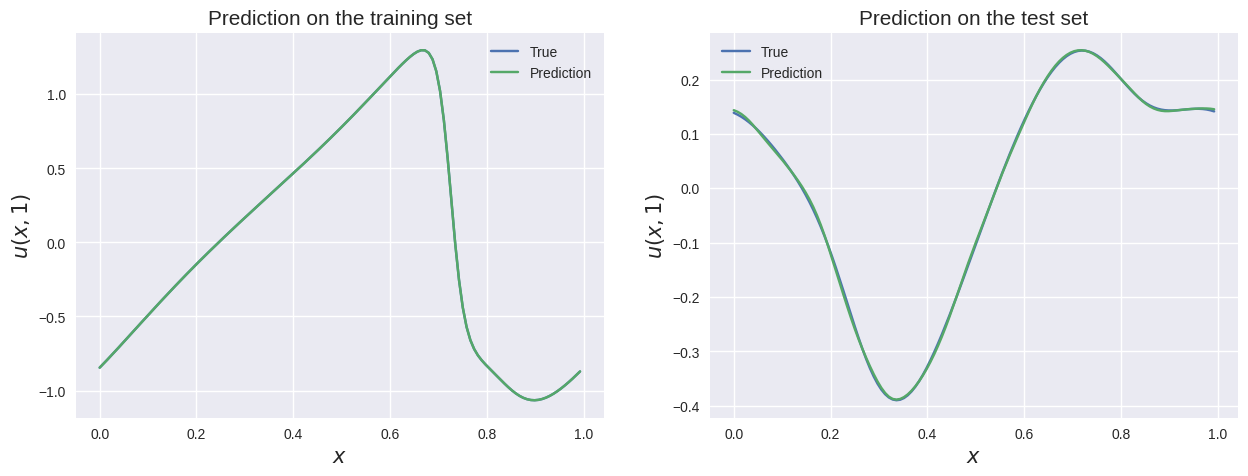

In [4]:
def train_test(x_train, x_test, y_train, y_test):
    kernel = Matern(nu = 2.5, length_scale = 1.0)
    gp = GaussianProcessRegressor(kernel, alpha = 1e-10,  normalize_y = False, random_state= 6032023) 
    
    gp.fit(x_train, y_train)
    pred= gp.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, gp

pred, GP = train_test(x, x_test, y, y_test)
pred_train = GP.predict(x)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e_train = np.mean(np.linalg.norm(pred_train - y, axis = -1)/np.linalg.norm(y, axis = -1))

print("Error without cholesky preconditioning")
print(e, e_train)
idx = 15
i = 0

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()



# With cholesky preconditioning

In [85]:
kernel_u =Matern(nu = 1.5, length_scale = 0.1) 
kernel_v = Matern(nu = 1.5, length_scale = 0.1)

def cholesky_transform(kernel_u, kernel_v, grid, u, v):
    K = kernel_u(grid)
    G = kernel_v(grid)

    tau = 1e-8
    L_K = cholesky(K + tau*np.eye(K.shape[0]), lower=True)
    L_G = cholesky(G+ tau*np.eye(K.shape[0]), lower = False)

    tau = 0
    #L_K_inv = np.linalg.inv(L_K + tau*np.eye(K.shape[0]))
    L_G_inv = np.linalg.inv(L_G + tau*np.eye(K.shape[0]))

        
    return (L_K.T @ u[:, :, None]).squeeze(-1), (L_G_inv.T @ v[:, :, None]).squeeze(-1)

x_train, y_train = cholesky_transform(kernel_u, kernel_v, grid, x, y)
x_val, y_val = cholesky_transform(kernel_u, kernel_v, grid, x_test, y_test)

In [86]:
def optimal_recovery(kernel_u, kernel_v, grid, u, v):
    K = kernel_u(grid)
    G = kernel_v(grid)
    #print(np.linalg.cond(K))

    tau = 1e-8
    L_K = cholesky(K + tau*np.eye(K.shape[0]), lower=True)
    L_G = cholesky(G+ tau*np.eye(K.shape[0]), lower = False)

    tau = 0
    #L_K_inv = np.linalg.inv(L_K + tau*np.eye(K.shape[0]))
    L_G_inv = np.linalg.inv(L_G + tau*np.eye(K.shape[0]))
    
    u = np.linalg.solve(L_K.T, u[:, :, None]).squeeze(-1)
    #u_recov = np.squeeze(K@scipy.linalg.cho_solve((L_K, True), u[None] ))
    u_recov = np.squeeze(K@scipy.linalg.solve(K, u.T, assume_a = 'pos' )).T
    v_recov = np.squeeze(G@L_G_inv@v[:, :, None])
    
    return u_recov, v_recov

u_recov, v_recov = optimal_recovery(kernel_u, kernel_v, grid, x_train, y_train)
    
e_u = np.mean(np.linalg.norm(u_recov - x, axis = -1)/np.linalg.norm(x, axis = -1))
e_v = np.mean(np.linalg.norm(v_recov - y, axis = -1)/np.linalg.norm(y, axis = -1))

print(e_u, e_v)


u_recov, v_recov = optimal_recovery(kernel_u, kernel_v, grid, x_val, y_val)
    
e_u = np.mean(np.linalg.norm(u_recov - x_test, axis = -1)/np.linalg.norm(x_test, axis = -1))
e_v = np.mean(np.linalg.norm(v_recov - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

print(e_u, e_v)


5.3145822526524455e-14 6.83929619359285e-09
5.238858735531739e-14 6.540989420328464e-09


In [87]:
# Using the cholesky preconditioning


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)
e = np.mean(np.linalg.norm(pred - y_val, axis = -1)/np.linalg.norm(y_val, axis = -1))
e_train = np.mean(np.linalg.norm(pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1))


print(e, e_train)

print(gp.kernel_)

KeyboardInterrupt: 

In [ ]:
#%% Recovering the pointwise measurements

_, pred_point_train = optimal_recovery(kernel_u, kernel_v, grid, x_train, pred_train)
_, pred_point = optimal_recovery(kernel_u, kernel_v, grid, x_val, pred)

e = np.mean(np.linalg.norm(pred_point - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e_train = np.mean(np.linalg.norm(pred_point_train - y, axis = -1)/np.linalg.norm(y, axis = -1))

print("Error with cholesky preconditioning")
print(e, e_train)

idx = 15

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y[idx], label = "True")
ax1.plot(grid, pred_point_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred_point[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

# More efficient code

In [5]:
def compute_cho(kernel_u, kernel_v, grid):
    K = kernel_u(grid)
    G = kernel_v(grid)
    #print(np.linalg.cond(K))

    tau = 1e-8
    L_K = cholesky(K + tau*np.eye(K.shape[0]), lower=True)
    L_G = cholesky(G+ tau*np.eye(G.shape[0]), lower = False)
    
    return L_K, L_G

def precondition(L_K, L_G, u ,v):
    tau = 1e-8
    L_G_inv = np.linalg.inv(L_G + tau*np.eye(L_G.shape[0]))    
    return (L_K.T @ u[:, :, None]).squeeze(-1), (L_G_inv.T @ v[:, :, None]).squeeze(-1)
    
def compute_error(prediction, target):
    e = np.mean(np.linalg.norm(prediction - target, axis = -1)/np.linalg.norm(target, axis = -1))
    
    return e

def optimal_recovery(K, G, L_K, L_G, u, v):
    tau = 0
    #L_K_inv = np.linalg.inv(L_K + tau*np.eye(K.shape[0]))
    L_G_inv = np.linalg.inv(L_G + tau*np.eye(K.shape[0]))
    
    u = np.linalg.solve(L_K.T, u[:, :, None]).squeeze(-1)
    #u_recov = np.squeeze(K@scipy.linalg.cho_solve((L_K, True), u[None] ))
    u_recov = np.squeeze(K@scipy.linalg.solve(K, u.T, assume_a = 'pos' )).T
    v_recov = np.squeeze(G@L_G_inv@v[:, :, None])
    
    return u_recov, v_recov
    

In [6]:
kernel_u =Matern(nu = 1.5, length_scale = 0.01) 
kernel_v = Matern(nu = 1.5, length_scale = 1e-10)
L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.0296194201392481 1.5169244723738143e-08


In [7]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.029619420454446484 2.6403287774330912e-08


In [121]:
pred = y_val
pred_train = y_train

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.0 0.0


In [8]:
kernel_u =Matern(nu = 1.5, length_scale = 0.1) 
kernel_v = Matern(nu = 1.5, length_scale = 0.0001)
L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)


0.021571493679158494 3.264527999087407e-08


In [9]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.021571493801857272 4.0771770800403885e-08


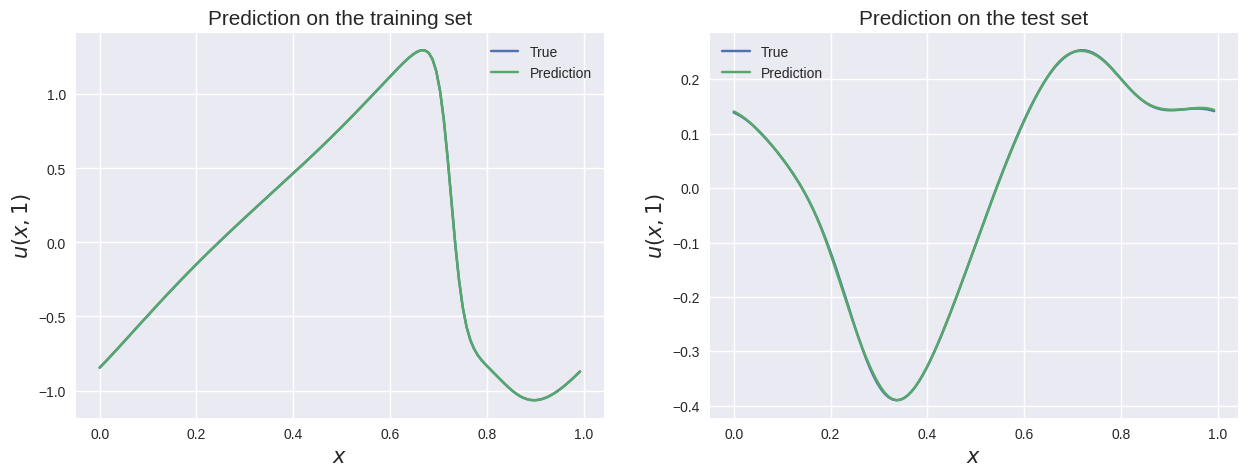

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y[idx], label = "True")
ax1.plot(grid, pred_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()


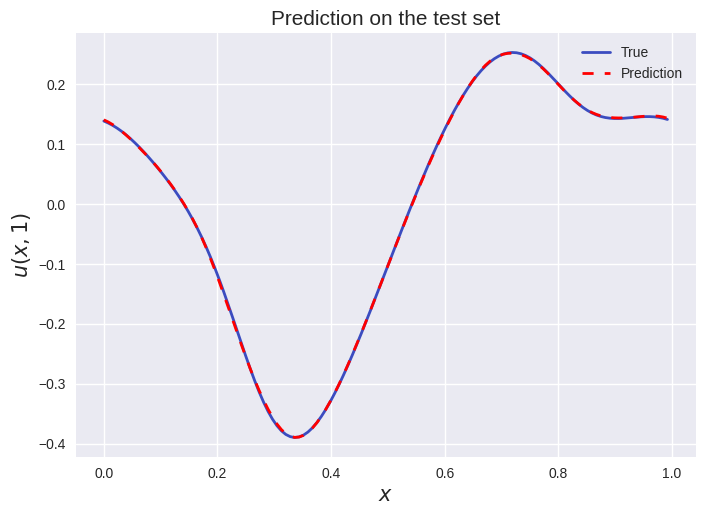

In [47]:


plt.plot(grid, y_test[idx],  label = "True",  linewidth=2.0, color= cm.coolwarm(0.0))
plt.plot(grid, pred[idx],  label = "Prediction", linestyle='--',dashes=(4, 4), color = 'red',  linewidth=2.0)
plt.xlabel(r'$x$', size= 15)
plt.ylabel(r'$u(x, 1)$', size= 15)
plt.title("Prediction on the test set", size = 15)
plt.legend()


# Using bayesian optimization

In [61]:
from skopt import gp_minimize
from sklearn.model_selection import KFold

In [62]:
def f_cv(x, y, nu_u, l_u, nu_v, l_v):
    
    kernel_u = Matern(nu = nu_u, length_scale = l_u) 
    kernel_v = Matern(nu = nu_v, length_scale = l_v)
    
    print(kernel_u, kernel_v)
    
    kf = KFold(n_splits=5)
    
    L_K, L_G = compute_cho(kernel_u, kernel_v, grid)
    
    e = 0
    for train_index, test_index in kf.split(x):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        x_train, y_train = precondition(L_K, L_G, X_train, y_train)
        x_val, y_val = precondition(L_K, L_G, X_test, y_test)
        
        pred, gp = train_test(x_train, x_val, y_train, y_val)
        
        e += compute_error(pred, y_val)
    print(e/5)
    return (e/5).item()

In [63]:
f_opt = lambda param: f_cv(x, y, param[0], param[1], param[2], param[3])

In [64]:
# Defining the search space

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

space= [ Categorical([0.5, 1.5, 2.5, np.inf], name='nu_u'),
        Real(0.00001, 100.0, name='length_scale_u'),
        Categorical([0.5, 1.5, 2.5, np.inf], name='nu_v'),
        Real(0.00001, 100.0, name='length_scale_v')
         ]

x0 = [1.5, 0.1, 1.5, 0.1]

In [65]:
x0 = [1.5, 0.1, 1.5, 0.001]
f_opt(x0)

Matern(length_scale=0.1, nu=1.5) Matern(length_scale=0.001, nu=1.5)
0.025238987849327967


0.025238987849327967

In [66]:
x0 = [1.5, 0.1, 1.5, 0.1]
f_opt(x0)

Matern(length_scale=0.1, nu=1.5) Matern(length_scale=0.1, nu=1.5)
0.1631925391982087


0.1631925391982087

In [22]:
n_calls = 100
n_start = 10

res = gp_minimize(f_opt,                  # the function to minimize
                  space,      # the bounds on each dimension of x
                  n_calls=n_calls,         # the number of evaluations of f
                  n_initial_points=n_start,  # the number of random initialization points
                  random_state=1234,
                 verbose = True,
                  x0 = x0
                 ) 

Iteration No: 1 started. Evaluating function at provided point.
Matern(length_scale=0.1, nu=1.5) Matern(length_scale=0.001, nu=1.5)
0.1631925391982087
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 36.9257
Function value obtained: 0.1632
Current minimum: 0.1632
Iteration No: 2 started. Evaluating function at random point.
Matern(length_scale=81.8, nu=1.5) Matern(length_scale=77.1, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.2958
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 3 started. Evaluating function at random point.
Matern(length_scale=15.1, nu=inf) Matern(length_scale=81.5, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.2387
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 4 started. Evaluating function at random point.
Matern(length_scale=11.6, nu=0.5) Matern(length_scale=48.7, nu=0.5)
0.17786899810600265
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 43.1164
Function value obtained: 0.1779
Current minimum: 0.1632
Iteration No: 5 started. Evaluating function at random point.
Matern(length_scale=80.3, nu=1.5) Matern(length_scale=5.6, nu=0.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.2086
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 6 started. Evaluating function at random point.
Matern(length_scale=2.21, nu=1.5) Matern(length_scale=24.6, nu=1.5)
0.2620264185149447
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 31.9434
Function value obtained: 0.2620
Current minimum: 0.1632
Iteration No: 7 started. Evaluating function at random point.
Matern(length_scale=88.9, nu=2.5) Matern(length_scale=11.7, nu=inf)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 5.0729
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 8 started. Evaluating function at random point.
Matern(length_scale=45.3, nu=1.5) Matern(length_scale=79.1, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 5.1468
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 9 started. Evaluating function at random point.
Matern(length_scale=43.5, nu=1.5) Matern(length_scale=96.9, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 5.2198
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 10 started. Evaluating function at random point.
Matern(length_scale=54.8, nu=0.5) Matern(length_scale=37.6, nu=1.5)
0.1784680809649467
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 32.1861
Function value obtained: 0.1785
Current minimum: 0.1632
Iteration No: 11 started. Evaluating function at random point.
Matern(length_scale=81.4, nu=1.5) Matern(length_scale=4.74, nu=2.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 5.3563
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 12 started. Evaluating function at random point.
Matern(length_scale=33.2, nu=0.5) Matern(length_scale=1e-05, nu=2.5)
0.17836157018876556
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 26.1813
Function value obtained: 0.1784
Current minimum: 0.1632
Iteration No: 13 started. Searching for the next optimal point.
Matern(length_scale=20.1, nu=0.5) Matern(length_scale=100, nu=1.5)
0.17818691510979243
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 30.5967
Function value obtained: 0.1782
Current minimum: 0.1632
Iteration No: 14 started. Searching for the next optimal point.
Matern(length_scale=100, nu=0.5) Matern(length_scale=1e-05, nu=inf)
0.1785423921679627
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 29.9822
Function value obtained: 0.1785
Current minim

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 5.4955
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 24 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=2.5) Matern(length_scale=99.9, nu=2.5)
0.21677582287713903
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 34.8437
Function value obtained: 0.2168
Current minimum: 0.1632
Iteration No: 25 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=1.5) Matern(length_scale=71.4, nu=0.5)
0.21677582287713903
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 35.0685
Function value obtained: 0.2168
Current minimum: 0.1632
Iteration No: 26 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=1.5) Matern(length_scale=1e-05, nu=inf)
0.21677582287713903
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 34.9989
Function value ob

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.21677582287713903
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 34.8909
Function value obtained: 0.2168
Current minimum: 0.1632
Iteration No: 35 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=2.5) Matern(length_scale=1e-05, nu=0.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.21677582287713903
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 34.6688
Function value obtained: 0.2168
Current minimum: 0.1632
Iteration No: 36 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=2.5) Matern(length_scale=1e-05, nu=0.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.21677582287713903
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 34.6870
Function value obtained: 0.2168
Current minimum: 0.1632
Iteration No: 37 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=2.5) Matern(length_scale=1e-05, nu=0.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.21677582287713903
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 34.6188
Function value obtained: 0.2168
Current minimum: 0.1632
Iteration No: 38 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=0.5) Matern(length_scale=1e-05, nu=0.5)
0.21677582287713903
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 34.7986
Function value obtained: 0.2168
Current minimum: 0.1632
Iteration No: 39 started. Searching for the next optimal point.
Matern(length_scale=72, nu=0.5) Matern(length_scale=100, nu=0.5)
0.17850732286754784
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 32.7877
Function value obtained: 0.1785
Current minimum: 0.1632
Iteration No: 40 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=2.5) Matern(length_scale=18.3, nu=1.5)
0.21677582287713903
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 34.6347
Func

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 5.4323
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 42 started. Searching for the next optimal point.
Matern(length_scale=44.5, nu=0.5) Matern(length_scale=1e-05, nu=0.5)
0.17843006986788817
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 32.2067
Function value obtained: 0.1784
Current minimum: 0.1632
Iteration No: 43 started. Searching for the next optimal point.
Matern(length_scale=13, nu=0.5) Matern(length_scale=1e-05, nu=inf)
0.17794773382121906
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 36.9978
Function value obtained: 0.1779
Current minimum: 0.1632
Iteration No: 44 started. Searching for the next optimal point.
Matern(length_scale=93.9, nu=0.5) Matern(length_scale=1e-05, nu=0.5)
0.17853656744995194
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 29.8998
Function value obtai

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.16757073367565378
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 51.2863
Function value obtained: 0.1676
Current minimum: 0.1632
Iteration No: 50 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=1.5) Matern(length_scale=100, nu=1.5)
0.21677582287713903
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 34.7519
Function value obtained: 0.2168
Current minimum: 0.1632
Iteration No: 51 started. Searching for the next optimal point.
Matern(length_scale=23.4, nu=0.5) Matern(length_scale=100, nu=0.5)
0.17825002772923676
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 37.1309
Function value obtained: 0.1783
Current minimum: 0.1632
Iteration No: 52 started. Searching for the next optimal point.
Matern(length_scale=50.7, nu=0.5) Matern(length_scale=1e-05, nu=inf)
0.1784547627799455
Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 32.1699
Funct

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.1785423921679627
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 30.5549
Function value obtained: 0.1785
Current minimum: 0.1632
Iteration No: 75 started. Searching for the next optimal point.
Matern(length_scale=53.9, nu=0.5) Matern(length_scale=99, nu=0.5)
0.17846530699081525
Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 32.5197
Function value obtained: 0.1785
Current minimum: 0.1632
Iteration No: 76 started. Searching for the next optimal point.
Matern(length_scale=95.2, nu=0.5) Matern(length_scale=100, nu=inf)
0.1785378187076006
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 30.1087
Function value obtained: 0.1785
Current minimum: 0.1632
Iteration No: 77 started. Searching for the next optimal point.
Matern(length_scale=8.76, nu=0.5) Matern(length_scale=100, nu=0.5)
0.17762802559827356
Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 30.5697
Function v

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 5.7465
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 82 started. Searching for the next optimal point.
Matern(length_scale=40.4, nu=0.5) Matern(length_scale=0.38, nu=0.5)
0.17840957349616118
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 32.2201
Function value obtained: 0.1784
Current minimum: 0.1632
Iteration No: 83 started. Searching for the next optimal point.
Matern(length_scale=58.9, nu=0.5) Matern(length_scale=98.5, nu=inf)
0.1784795450296602
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 32.6886
Function value obtained: 0.1785
Current minimum: 0.1632
Iteration No: 84 started. Searching for the next optimal point.
Matern(length_scale=11.6, nu=0.5) Matern(length_scale=99.6, nu=inf)
0.17786750785727787
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 42.3079
Function value obtaine

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 5.8710
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 86 started. Searching for the next optimal point.
Matern(length_scale=13, nu=0.5) Matern(length_scale=1e-05, nu=0.5)
0.17794667990752028
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 37.4692
Function value obtained: 0.1779
Current minimum: 0.1632
Iteration No: 87 started. Searching for the next optimal point.
Matern(length_scale=69, nu=inf) Matern(length_scale=25.5, nu=inf)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matthieudarcy/anaconda3/lib/python3.9/site-packag

1.0
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 5.8476
Function value obtained: 1.0000
Current minimum: 0.1632
Iteration No: 88 started. Searching for the next optimal point.
Matern(length_scale=28.2, nu=0.5) Matern(length_scale=96.8, nu=0.5)
0.1783138913961236
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 22.3728
Function value obtained: 0.1783
Current minimum: 0.1632
Iteration No: 89 started. Searching for the next optimal point.
Matern(length_scale=95.9, nu=0.5) Matern(length_scale=98.5, nu=0.5)
0.17853853935423697
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 30.1893
Function value obtained: 0.1785
Current minimum: 0.1632
Iteration No: 90 started. Searching for the next optimal point.
Matern(length_scale=68.8, nu=0.5) Matern(length_scale=3.85, nu=0.5)
0.17850138139702254
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 35.6124
Function value obtaine

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.17837081246981495
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 43.5035
Function value obtained: 0.1784
Current minimum: 0.1632
Iteration No: 96 started. Searching for the next optimal point.
Matern(length_scale=66.1, nu=0.5) Matern(length_scale=93.6, nu=inf)
0.1784961857286415
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 35.6374
Function value obtained: 0.1785
Current minimum: 0.1632
Iteration No: 97 started. Searching for the next optimal point.
Matern(length_scale=6.52, nu=0.5) Matern(length_scale=95.5, nu=0.5)
0.17729580795380406
Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 32.8302
Function value obtained: 0.1773
Current minimum: 0.1632
Iteration No: 98 started. Searching for the next optimal point.
Matern(length_scale=76.8, nu=0.5) Matern(length_scale=2.3, nu=inf)
0.17851515219465958
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 32.8664
Functi

In [27]:
param_opt = res.x
param_opt

[1.5, 0.1, 1.5, 0.001]

In [28]:
kernel_u =Matern(nu = param_opt[0], length_scale = param_opt[1]) 
kernel_v = Matern(nu = param_opt[2], length_scale = param_opt[3])

L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.021571530482378646 3.264642524501974e-08


In [29]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.021571501309311243 4.077237628220242e-08


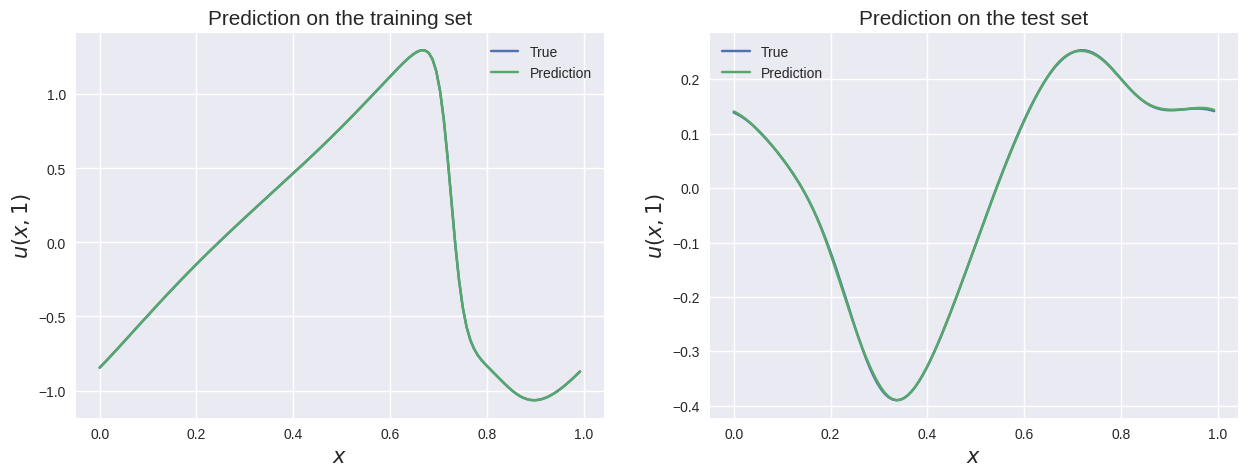

In [30]:
idx = 15

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y[idx], label = "True")
ax1.plot(grid, pred_point_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred_point[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

# Using bayesian optimization v2

In [67]:
from skopt import gp_minimize
from sklearn.model_selection import KFold

In [73]:
def f_cv(x, y, l_u,  l_v):
    
    kernel_u = Matern(nu = 1.5, length_scale = l_u) 
    kernel_v = Matern(nu = 1.5, length_scale = l_v)
    
    print(kernel_u, kernel_v)
    
    kf = KFold(n_splits=5)
    
    L_K, L_G = compute_cho(kernel_u, kernel_v, grid)
    
    #print(L_G[0])
    
    e = 0
    for train_index, test_index in kf.split(x):
        #print("TRAIN:", train_index, "TEST:", test_index)
        
        x_train, y_train = precondition(L_K, L_G, x[train_index], y[train_index])
        x_val, y_val = precondition(L_K, L_G, x[test_index], y[test_index])
        
        pred, gp = train_test(x_train, x_val, y_train, y_val)
        
        e += compute_error(pred, y_val)
    #print(e/5)
    return (e/5).item()

In [69]:
f_opt = lambda param: f_cv(x, y, param[0], param[1])

In [70]:
# Defining the search space

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

space= [ 
        Real(0.00001, 100.0, name='length_scale_u'),
        Real(0.00001, 100.0, name='length_scale_v')
         ]


In [79]:
x0 = [0.1, 0.001]
f_opt(x0)

Matern(length_scale=0.1, nu=1.5) Matern(length_scale=0.001, nu=1.5)
0.025238987849327967


0.025238987849327967

In [80]:
n_calls = 100
n_start = 10

x0 = [0.1, 0.001]

space= [ 
        Real(0.00001, 1.0, name='length_scale_u'),
        Real(0.00001, 1.0, name='length_scale_v')
         ]

res = gp_minimize(f_opt,                  # the function to minimize
                  space,      # the bounds on each dimension of x
                  n_calls=n_calls,         # the number of evaluations of f
                  n_initial_points=n_start,  # the number of random initialization points
                  random_state=1234,
                 verbose = True,
                  x0 = x0
                 ) 

Iteration No: 1 started. Evaluating function at provided point.
Matern(length_scale=0.1, nu=1.5) Matern(length_scale=0.001, nu=1.5)
0.025238987849327967
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 43.9888
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 2 started. Evaluating function at random point.
Matern(length_scale=0.498, nu=1.5) Matern(length_scale=0.818, nu=1.5)
0.5367167052876545
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.0549
Function value obtained: 0.5367
Current minimum: 0.0252
Iteration No: 3 started. Evaluating function at random point.
Matern(length_scale=0.612, nu=1.5) Matern(length_scale=0.771, nu=1.5)
0.561829109819838
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 29.5217
Function value obtained: 0.5618
Current minimum: 0.0252
Iteration No: 4 started. Evaluating function at random point.
Matern(length_scale=0.861, nu=1.5) Matern(length_scale=0.151, nu=1.5)
0.30734786711319

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.04756285795414463
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 49.7325
Function value obtained: 0.0476
Current minimum: 0.0252
Iteration No: 11 started. Evaluating function at random point.
Matern(length_scale=0.291, nu=1.5) Matern(length_scale=0.246, nu=1.5)
0.3047925491310515
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 53.7157
Function value obtained: 0.3048
Current minimum: 0.0252
Iteration No: 12 started. Evaluating function at random point.
Matern(length_scale=0.286, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.031994451816635225
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 34.2692
Function value obtained: 0.0320
Current minimum: 0.0252
Iteration No: 13 started. Searching for the next optimal point.
Matern(length_scale=1e-05, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.03443603319758355
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 36.7973
Function value obtained: 0.0344
C

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.03443603319758355
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 36.7504
Function value obtained: 0.0344
Current minimum: 0.0252
Iteration No: 18 started. Searching for the next optimal point.
Matern(length_scale=0.154, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02618088707732682
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 39.5412
Function value obtained: 0.0262
Current minimum: 0.0252
Iteration No: 19 started. Searching for the next optimal point.
Matern(length_scale=0.109, nu=1.5) Matern(length_scale=1e-05, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025235868664532042
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 54.9251
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 20 started. Searching for the next optimal point.
Matern(length_scale=0.113, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025265777596469235
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 43.9498
Function value obtained: 0.0253
Current minimum: 0.0252
Iteration No: 21 started. Searching for the next optimal point.
Matern(length_scale=0.116, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025289086061577554
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 44.1018
Function value obtained: 0.0253
Current minimum: 0.0252
Iteration No: 22 started. Searching for the next optimal point.
Matern(length_scale=1, nu=1.5) Matern(length_scale=0.45, nu=1.5)
0.5339323846939052
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 29.4149
F

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.02524103669510791
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 57.5048
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 30 started. Searching for the next optimal point.
Matern(length_scale=0.11, nu=1.5) Matern(length_scale=1e-05, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.02524281226465634
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 57.8151
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 31 started. Searching for the next optimal point.
Matern(length_scale=0.11, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02524322950367263
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 47.7150
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 32 started. Searching for the next optimal point.
Matern(length_scale=0.129, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02550001376322918
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 44.4960
Function value obtained: 0.0255
Current minimum: 0.0252
Iteration No: 33 started. Searching for the next optimal point.
Matern(length_scale=0.107, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02523074937907367
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 50.0696

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025254396195566204
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 57.9308
Function value obtained: 0.0253
Current minimum: 0.0252
Iteration No: 40 started. Searching for the next optimal point.
Matern(length_scale=0.112, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02525330584129599
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 44.4240
Function value obtained: 0.0253
Current minimum: 0.0252
Iteration No: 41 started. Searching for the next optimal point.
Matern(length_scale=0.112, nu=1.5) Matern(length_scale=1e-05, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025252384028589397
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 62.3457
Function value obtained: 0.0253
Current minimum: 0.0252
Iteration No: 42 started. Searching for the next optimal point.
Matern(length_scale=0.124, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025405053856754668
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 44.4608
Function value obtained: 0.0254
Current minimum: 0.0252
Iteration No: 43 started. Searching for the next optimal point.
Matern(length_scale=0.11, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025240761285066173
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 45.4867
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 44 started. Searching for the next optimal point.
Matern(length_scale=0.109, nu=1.5) Matern(length_scale=1e-05, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025237406204834313
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 64.2500
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 45 started. Searching for the next optimal point.
Matern(length_scale=0.109, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025237807342360093
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 47.9208
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 46 started. Searching for the next optimal point.
Matern(length_scale=0.109, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025237879745432394
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 45.8274
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 47 started. Searching for the next optimal point.
Matern(length_scale=0.109, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.0252381708183461
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 44.4

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025232000030218537
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 58.5825
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 51 started. Searching for the next optimal point.
Matern(length_scale=0.107, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02523095696793175
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 56.7758
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 52 started. Searching for the next optimal point.
Matern(length_scale=0.108, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025232621199894445
Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 52.2827
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 53 started. Searching for the next optimal point.
Matern(length_scale=0.107, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025231689293198745
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 52.

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025231008416006267
Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 57.1628
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 56 started. Searching for the next optimal point.
Matern(length_scale=0.107, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02523129905297457
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 45.3335
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 57 started. Searching for the next optimal point.
Matern(length_scale=0.107, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02523107263718013
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 51.7955
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 58 started. Searching for the next optimal point.
Matern(length_scale=0.118, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025317823758266467
Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 44.1

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025228655272242283
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 57.6656
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 68 started. Searching for the next optimal point.
Matern(length_scale=0.106, nu=1.5) Matern(length_scale=1e-05, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025228402555128572
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 57.4693
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 69 started. Searching for the next optimal point.
Matern(length_scale=0.106, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02522821892487679
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 51.7903
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 70 started. Searching for the next optimal point.
Matern(length_scale=0.106, nu=1.5) Matern(length_scale=1e-05, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.02522869392660728
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 61.9375
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 71 started. Searching for the next optimal point.
Matern(length_scale=0.116, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025294896676637514
Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 44.2808
Function value obtained: 0.0253
Current minimum: 0.0252
Iteration No: 72 started. Searching for the next optimal point.
Matern(length_scale=0.105, nu=1.5) Matern(length_scale=1e-05, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025227789729006106
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 58.0236
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 73 started. Searching for the next optimal point.
Matern(length_scale=0.106, nu=1.5) Matern(length_scale=1e-05, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.025228083091169973
Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 58.2333
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 74 started. Searching for the next optimal point.
Matern(length_scale=0.106, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02522809247969291
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 48.0025
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 75 started. Searching for the next optimal point.
Matern(length_scale=0.116, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02529176871748156
Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 44.0851
Function value obtained: 0.0253
Current minimum: 0.0252
Iteration No: 76 started. Searching for the next optimal point.
Matern(length_scale=0.105, nu=1.5) Matern(length_scale=1e-05, nu=1.5)


/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.02522770660546108
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 68.2909
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 77 started. Searching for the next optimal point.
Matern(length_scale=0.106, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025228056436443845
Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 44.1947
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 78 started. Searching for the next optimal point.
Matern(length_scale=0.105, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02522772292007087
Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 51.8766
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 79 started. Searching for the next optimal point.
Matern(length_scale=0.105, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02522795881502592
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 48.92

/home/matthieudarcy/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.02522791772696665
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 66.8035
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 85 started. Searching for the next optimal point.
Matern(length_scale=0.115, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.02527883155584098
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 45.0139
Function value obtained: 0.0253
Current minimum: 0.0252
Iteration No: 86 started. Searching for the next optimal point.
Matern(length_scale=0.105, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.025227879866109776
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 44.7835
Function value obtained: 0.0252
Current minimum: 0.0252
Iteration No: 87 started. Searching for the next optimal point.
Matern(length_scale=0.113, nu=1.5) Matern(length_scale=1e-05, nu=1.5)
0.0252606279372534
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 44.918

In [81]:
param_opt = res.x
param_opt

[0.10454448751993922, 1e-05]

In [127]:
kernel_u =Matern(nu = 1.5, length_scale = param_opt[0]) 
kernel_v = Matern(nu = 1.5, length_scale = param_opt[1])

kernel_v = WhiteKernel()


In [128]:
L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.021528960378950704 3.3551900629543516e-08


In [129]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.021528960491490615 4.16044641159659e-08


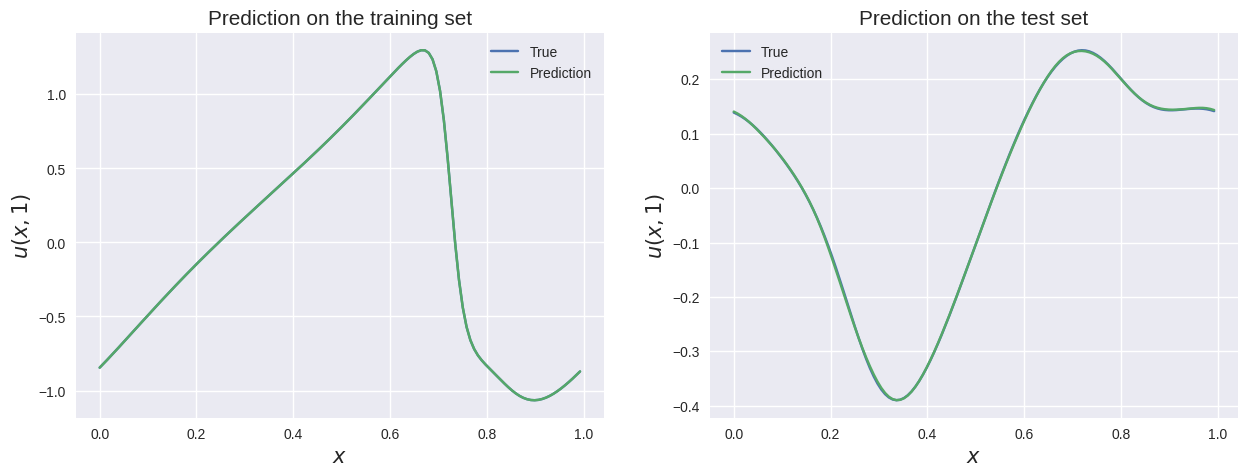

In [130]:
idx = 15

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y[idx], label = "True")
ax1.plot(grid, pred_point_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred_point[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()

In [131]:
kernel_u =Matern(nu = 1.5, length_scale = param_opt[0]) 
kernel_v = Matern(nu = 1.5, length_scale = param_opt[1])

In [132]:
L_K, L_G = compute_cho(kernel_u, kernel_v, grid)

x_train, y_train = precondition(L_K, L_G, x, y)
x_val, y_val = precondition(L_K, L_G, x_test, y_test)


pred, gp = train_test(x_train, x_val, y_train, y_val)
pred_train = gp.predict(x_train)

e = compute_error(pred, y_val)
e_train = compute_error(pred_train, y_train)
print(e, e_train)

0.021528960378950704 3.3551900629543516e-08


In [133]:
# pointwise prediction
K = kernel_u(grid)
G = kernel_v(grid)
_, pred_train_point = optimal_recovery(K, G, L_K, L_G, x_train, pred_train)
_, pred_point = optimal_recovery(K, G, L_K, L_G, x_val, pred)

e = compute_error(pred_point, y_test)
e_train = compute_error(pred_train_point, y)
print(e, e_train)

0.021528960491490615 4.16044641159659e-08


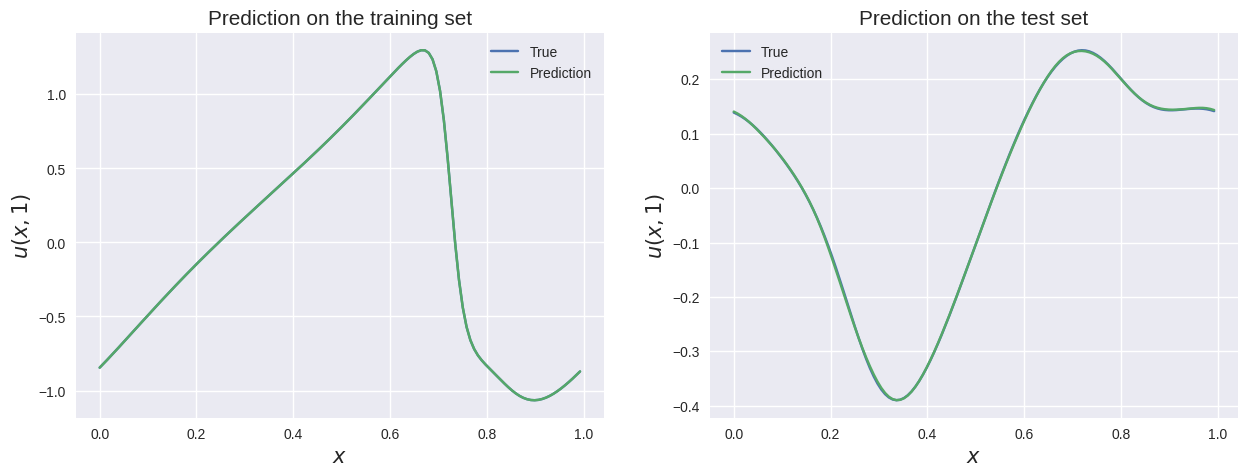

In [134]:
idx = 15

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.plot(grid, y[idx], label = "True")
ax1.plot(grid, pred_point_train[idx], label = "Prediction")
ax1.set_xlabel(r'$x$', size= 15)
ax1.set_ylabel(r'$u(x,1)$', size= 15)
ax1.set_title("Prediction on the training set", size = 15)
ax1.legend()

ax2.plot(grid, y_test[idx],  label = "True")
ax2.plot(grid, pred_point[idx],  label = "Prediction")
ax2.set_xlabel(r'$x$', size= 15)
ax2.set_ylabel(r'$u(x, 1)$', size= 15)
ax2.set_title("Prediction on the test set", size = 15)
ax2.legend()